In [38]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from random import choice
import tensorflow as tf
import random
import matplotlib.pyplot as plt


# ---------------------------- Set Global Seed ----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


set_seed(42)

# ---------------------------- Data Preprocessing ----------------------------
# Load the dataset
url = 'Exercise7data.csv'
df = pd.read_csv(url)

# Drop specific columns
df = df.drop(['Arrival_time', 'Stop_id', 'Bus_id', 'Line_id'], axis=1)

# Define features and target variable
X = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


# ---------------------------- Neural Network Construction ----------------------------
def build_model(input_shape, layers, dropout_rate=0.2, optimizer_name='adam'):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))  # Ensure the input shape matches the number of features

    for layer_size in layers:
        model.add(Dense(layer_size, activation='relu'))
        model.add(Dropout(dropout_rate))  # Add Dropout

    model.add(Dense(1))  # Output layer

    # Select the optimizer
    optimizers = {
        'adam': Adam,
        'sgd': SGD,
        'rmsprop': RMSprop
    }

    optimizer = optimizers[optimizer_name]()

    # Compile the model with MAE and MSE metrics
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])

    return model


# ---------------------------- Model Evaluation ----------------------------
def evaluate_model(optimizer, layers, dropout_rate, epochs, batch_size):
    model = build_model(X_train.shape[1], layers, dropout_rate, optimizer)

    # Define callbacks inside the function to avoid reusing them
    early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)
    log_dir = f'logs/{int(time.time())}'
    tensorboard_callback = TensorBoard(log_dir=log_dir)

    start_time = time.time()  # Start the timer to measure training time

    # Training and capture of history
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,  # Use 20% of the training set as validation
        epochs=int(epochs),
        batch_size=int(batch_size),
        callbacks=[early_stop, reduce_lr, tensorboard_callback],
        verbose=0
    )

    end_time = time.time()
    training_time = end_time - start_time
    epochs_trained = len(history.history['loss'])

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Save results and training history
    return {
        'optimizer': optimizer,
        'layers': layers,
        'dropout_rate': dropout_rate,
        'epochs': epochs,
        'batch_size': batch_size,
        'mae': mae,
        'mse': mse,
        'r2': r2,
        'training_time': training_time,
        'epochs_trained': epochs_trained,
        'history': history.history  # Save the history to be able to plot later
    }


# Store results
results = []

# ---------------------------- Random Search ----------------------------
hyperparameter_space = {
    'optimizers': ['adam', 'sgd', 'rmsprop'],
    'layers_config': [
        [8, 8],
        [16, 8], [16, 16],
        [32, 16], [32, 32],
        [64, 32], [64, 64],
        [128, 64]
    ],
    'dropout_rates': [0.2, 0.3, 0.5],
    'epochs_options': [50, 100, 150],
    'batch_sizes': [16, 32, 64]
}

n_iterations = 100
for _ in range(n_iterations):
    optimizer = choice(hyperparameter_space['optimizers'])
    layers = choice(hyperparameter_space['layers_config'])
    dropout_rate = choice(hyperparameter_space['dropout_rates'])
    epochs = choice(hyperparameter_space['epochs_options'])
    batch_size = choice(hyperparameter_space['batch_sizes'])

    result = evaluate_model(
        optimizer, layers, dropout_rate, epochs, batch_size
    )
    results.append(result)

# ---------------------------- Selection and Plotting ----------------------------
# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results)
results_df

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━

,optimizer,layers,dropout_rate,epochs,batch_size,mae,mse,r2,training_time,epochs_trained,history
0,rmsprop,"[16, 8]",0.2,150,32,30.854675,2509.874546,0.835319,15.833380,26,"{'loss': [84.93976593017578, 84.36692810058594..."
1,rmsprop,"[16, 8]",0.5,100,16,33.236087,2883.740934,0.810788,15.796627,25,"{'loss': [84.67414093017578, 83.919921875, 82...."
2,rmsprop,"[8, 8]",0.5,50,64,37.987542,3587.641412,0.764603,10.930595,50,"{'loss': [84.66895294189453, 84.45335388183594..."
3,sgd,"[32, 32]",0.2,50,64,29.674018,2186.886113,0.856511,10.268505,50,"{'loss': [84.50838470458984, 83.87045288085938..."
4,sgd,"[16, 8]",0.2,100,16,30.532725,2374.072375,0.844229,6.785625,11,"{'loss': [83.8699722290039, 57.007347106933594..."
...,...,...,...,...,...,...,...,...,...,...,...
95,sgd,"[64, 32]",0.3,150,64,29.533172,2139.951773,0.859591,7.963202,40,"{'loss': [84.79304504394531, 84.26482391357422..."
96,sgd,"[32, 32]",0.2,50,64,29.819885,2257.463203,0.851880,6.644306,33,"{'loss': [84.77522277832031, 84.45663452148438..."
97,rmsprop,"[16, 16]",0.2,50,64,30.764851,2596.903937,0.829608,10.445480,50,"{'loss': [84.66571807861328, 84.10906219482422..."
98,rmsprop,"[32, 32]",0.2,50,32,29.440432,2118.495813,0.860998,14.903649,50,"{'loss': [83.60484313964844, 79.67398834228516..."


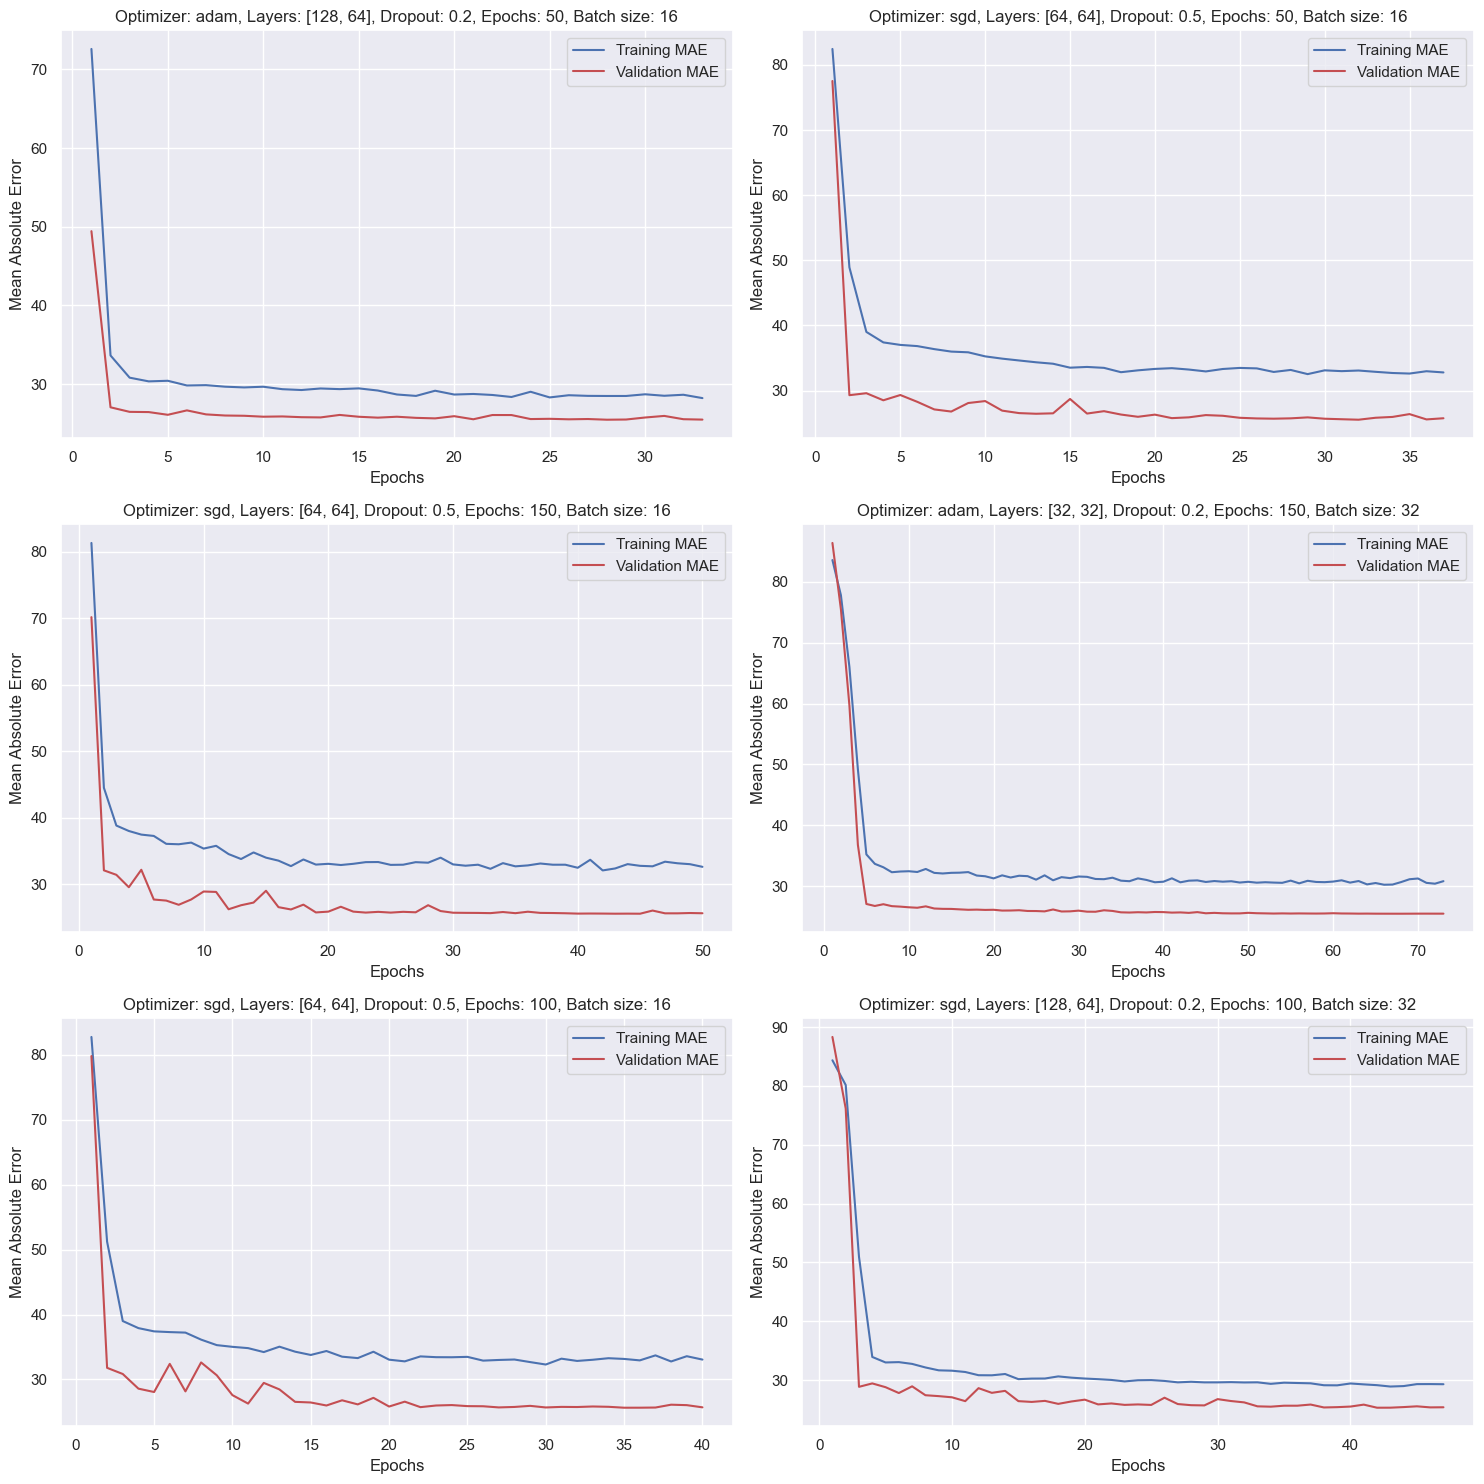

6 unique models were found.


In [39]:
results_df['layers'] = results_df['layers'].apply(lambda x: str(x))

# Select the top 5 combinations with highest R² and the top 5 with lowest MAE
top_r2 = results_df.nlargest(5, 'r2')
top_mae = results_df.nsmallest(5, 'mae')

# Combine the top_r2 and top_mae sets and remove duplicates considering only the relevant columns
top_results = pd.concat([top_r2, top_mae]).drop_duplicates(
    subset=['optimizer', 'layers', 'dropout_rate', 'epochs', 'batch_size'])

# Number of plots to display
num_plots = len(top_results)

# Create a figure with automatic subplots
fig, axes = plt.subplots(nrows=num_plots // 2 + num_plots % 2, ncols=2,
                         figsize=(15, 5 * (num_plots // 2 + num_plots % 2)))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot the combined results without duplicates
for i, (index, row) in enumerate(top_results.iterrows()):
    # Extract the history information
    history = row['history']
    err = history['mae']  # Training error (MAE)
    val_err = history['val_mae']  # Validation error (MAE)
    epochs_range = range(1, len(err) + 1)

    # Create the plot in the grid
    ax = axes[i]  # Select the appropriate subplot
    ax.plot(epochs_range, err, 'b-', label='Training MAE')
    ax.plot(epochs_range, val_err, 'r-', label='Validation MAE')

    # Title with the parameters used
    ax.set_title(f"Optimizer: {row['optimizer']}, Layers: {row['layers']}, Dropout: {row['dropout_rate']}, "
                 f"Epochs: {row['epochs']}, Batch size: {row['batch_size']}")

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Mean Absolute Error')
    ax.legend()

# If there are unused subplots, remove them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of plots
plt.show()

# Show how many unique models were found
print(f"{num_plots} unique models were found.")
